# Words Embeddings: Word2Vect
The idea now is to create an embedding of MTG card's text using Gensim, with Continous bag of words or SkipGram Word2Vect strategies. These methods are shallow neural networkds with the simple tasks of predicting a word given some context words (Continous bag of words) or infering context words given a center word (SkipGram).

In [7]:
import pandas as pd
import numpy as np

## Dataset retrieval
The file cards_nlp.csv must be available in the given path. Run the MTG NLP - 0 if not present. 

Get only the text for all the cards. 

In [8]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if(IN_COLAB):
    import gdown
    output_file = './mtgjson_dataset/cards_nlp.csv'
    file_url = 'https://drive.google.com/file/d/1j2e1Va8Tt6bccRUdXEahsJMZD2J1o7ds/view?usp=drive_link'
    gdown.download(url = file_url, output = output_file, fuzzy=True)

data = pd.read_csv('mtgjson_dataset\cards_nlp.csv')['text']
print('There are',data.shape[0],'unique cards/documents')
print(data.head(5))

There are 28941 unique cards/documents
0    This spell can't be countered.\nFlying, hexpro...
1       Other Goblins get +1/+1 and have mountainwalk.
2    Search your library for a basic land card, rev...
3    When this_card enters the battlefield, it deal...
4    Each player can't cast more than one spell eac...
Name: text, dtype: object


## Preprocessing
Using a basic and deprecated Keras function.

In [9]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
for _, row in pd.DataFrame(data[:None]).iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0],
                                                 filters = '!"#$%&()*,.;<=>?@[\\]^_`~\t\n'))

len(sentence_tokens)

28941

In [24]:
text_to_word_sequence(data.loc[10],'!"#$%&()*,.;<=>?@[\\]^_`~\t\n')

['when',
 'this',
 'card',
 'enters',
 'the',
 'battlefield',
 'create',
 'a',
 '0/1',
 'white',
 'goat',
 'creature',
 'token',
 'sacrifice',
 'another',
 'creature:',
 'scry',
 '1',
 'escape—{3}{b}{b}',
 'exile',
 'four',
 'other',
 'cards',
 'from',
 'your',
 'graveyard',
 'you',
 'may',
 'cast',
 'this',
 'card',
 'from',
 'your',
 'graveyard',
 'for',
 'its',
 'escape',
 'cost',
 'this',
 'card',
 'escapes',
 'with',
 'two',
 '+1/+1',
 'counters',
 'on',
 'it']

## Building model
Using Continous bag of words due to relatively small dataset.

In [10]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=4,
                     window=3,
                     vector_size=300,
                     negative=20,
                     workers=4,
                     sg=1)
w2v_model.build_vocab(sentence_tokens)

In [11]:
len(w2v_model.wv.index_to_key)

2193

## Model Training
I was tempted to use the Gensim Phrase detector but the vocabulary is small enough.

In [12]:
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1454352.875
Loss after epoch 1: 1307560.875
Loss after epoch 2: 1176480.0
Loss after epoch 3: 919858.75
Loss after epoch 4: 1177360.0
Loss after epoch 5: 930870.0
Loss after epoch 6: 895437.5
Loss after epoch 7: 856663.0
Loss after epoch 8: 1027616.0
Loss after epoch 9: 826224.0
Loss after epoch 10: 1029333.0
Loss after epoch 11: 1028688.0
Loss after epoch 12: 1026400.0
Loss after epoch 13: 1028225.0
Loss after epoch 14: 1028886.0
Loss after epoch 15: 893729.0
Loss after epoch 16: 972872.0
Loss after epoch 17: 964006.0
Loss after epoch 18: 962420.0
Loss after epoch 19: 957872.0
Loss after epoch 20: 811832.0
Loss after epoch 21: 959964.0
Loss after epoch 22: 786584.0
Loss after epoch 23: 815678.0
Loss after epoch 24: 1004582.0
Loss after epoch 25: 1004140.0
Loss after epoch 26: 952740.0
Loss after epoch 27: 996854.0
Loss after epoch 28: 782520.0
Loss after epoch 29: 951224.0
Loss after epoch 30: 953882.0
Loss after epoch 31: 948508.0
Loss after epoch 32: 956036.0
Los

(48035211, 79330600)

## Model saving
Save the full model, which allows further traning and querying, but its larger in size. Not a problem here since the vocabulary is quite small.

In [13]:
w2v_model.save('./mtgjson_dataset/mtg_skipgram.pkl')

In [14]:
w2v_model = Word2Vec.load('./mtgjson_dataset/mtg_skipgram.pkl')

## Exploration of similarities
I explored some of the most iconic keywords. For starters, _battlefield_ should have _enters_ at most similar for all the famous _Enters the battlefield_. SkipGram models correctly assume this while CBOW is nonsensical.

In [15]:
w2v_model.wv.most_similar(positive=["battlefield"], topn=10)

[('enters', 0.4730108678340912),
 ('deep', 0.3705030083656311),
 ('living', 0.36306536197662354),
 ('weapon', 0.3623068630695343),
 ('tribute', 0.3535882532596588),
 ('chakram', 0.3448064923286438),
 ('mirrodin', 0.3438473343849182),
 ('soulblade', 0.3352549970149994),
 ('converge', 0.33505886793136597),
 ('defense', 0.33489251136779785)]

_Trample_ shares the space with other iconic keywords (_haste_, _reach_, _vigilance_, etc). Actually, these are called _Evergreens_ as they are ever present and have existed since the 90s.  They also affect combat exclusively

In [16]:
w2v_model.wv.most_similar(positive=["trample"], topn=10)

[('haste', 0.4093132019042969),
 ('strike', 0.4049438536167145),
 ('flying', 0.3774895966053009),
 ('vigilance', 0.37223020195961),
 ('battalion', 0.3704255223274231),
 ('reach', 0.3677557110786438),
 ('celebration', 0.34546610713005066),
 ('+0/+5', 0.3451361656188965),
 ('regular', 0.34445905685424805),
 ('{s}{s}:', 0.3440852165222168)]

Curiously _Zombie_ shares the space with other sinister-like words. This is more a flavor similarity rather than a rules one, which is interesting.

In [17]:
w2v_model.wv.most_similar(positive=["zombie"], topn=10)

[('necron', 0.4625360369682312),
 ('orc', 0.45768821239471436),
 ('army', 0.3948063850402832),
 ('astartes', 0.39391598105430603),
 ('mutant', 0.39246320724487305),
 ('ooze', 0.3795575201511383),
 ('knight', 0.37882059812545776),
 ('rogue', 0.36498478055000305),
 ('bat', 0.36453643441200256),
 ('shark', 0.35771724581718445)]

_Astartes_ is a keyword from a set of cross-universe printings. Having _Necron_ as most similar is reassuring as they are opposites in-universe, making them extremely related. 

In [18]:
w2v_model.wv.most_similar(positive=["astartes"], topn=10)

[('necron', 0.6880306601524353),
 ('drake', 0.6086040735244751),
 ('inkling', 0.5890933871269226),
 ('gremlin', 0.5443791151046753),
 ('lizard', 0.5422348380088806),
 ('samurai', 0.5356261730194092),
 ('bat', 0.5348362326622009),
 ('alien', 0.5170364379882812),
 ('pegasus', 0.510123074054718),
 ('sand', 0.5066269040107727)]

_Tyranids_ is of the same universe from _Astartes_ but these where placed among animal-like creatures. Makes sense since Tyranids are like giant insects.

In [19]:
w2v_model.wv.most_similar(positive=["tyranid"], topn=10)

[('salamander', 0.5505353808403015),
 ('lizard', 0.5319151878356934),
 ('centaur', 0.500791072845459),
 ('ape', 0.4997643530368805),
 ('crab', 0.48345616459846497),
 ('drake', 0.4773228168487549),
 ('satyr', 0.4740871787071228),
 ('nightmare', 0.458524614572525),
 ('octopus', 0.4511173665523529),
 ('shark', 0.4451110363006592)]

_Rad_ counters, as in radiation, is from the _Fallout_ printing. The most similar ones are spot on since it's gameplay related to energy counters, tighly to _mill_ and it is a form of poision, both in game and realy life. 

In [20]:
w2v_model.wv.most_similar(positive=["rad"], topn=10)

[('poison', 0.4162561595439911),
 ('energy', 0.3822442889213562),
 ('lore', 0.3523305654525757),
 ('+1/+1', 0.3482106626033783),
 ('mills', 0.3475980758666992),
 ("'", 0.34719985723495483),
 ('kinds', 0.33552631735801697),
 ('delay', 0.3289005756378174),
 ('points', 0.327023446559906),
 ('pressure', 0.32588067650794983)]

## Visualization

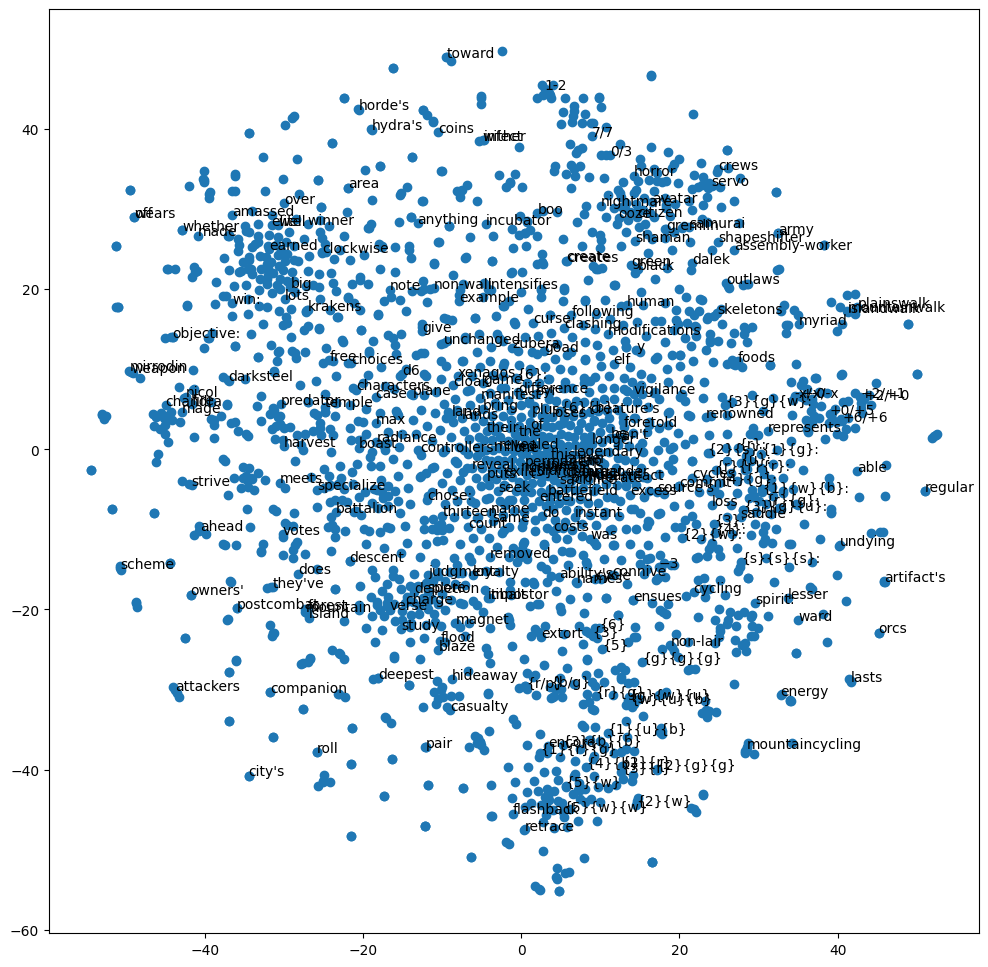

In [21]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, n_iter=4000)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)
    plt.plot()
    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 250)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

x_vals, y_vals, labels = reduce_dimensions(w2v_model)
plot_with_matplotlib(x_vals, y_vals, labels)

### For tensorflow projector
http://projector.tensorflow.org/

In [22]:
vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("./mtgjson_dataset/vectors.tsv", vectors, delimiter="\t")

with open("./mtgjson_dataset/labels.tsv", "w", encoding='utf8') as fp:
    for item in labels:
        fp.write("%s\n" % item)